# House Sales Prices Prediction Notebook
---

![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

## Introduction

In this notebook, I'm going to go over a basic Python data analysis pipeline from start to finish to show you what a typical data science workflow looks like.

Using Machine Learning algorithms to predict house sales prices from the tabular data.

- **Data Source**
    - The data set we're working with is come from Kaggle: Competition [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
    - Data sets include train and test. Train used for training Machine Learning model, test used for predicting the house sales prices as a target value for this problem.
    - Train is 50% data include information and price. Test is 50% data include information without price.
- **Mission**
    - Predicting the sales price for each house in the test data set.
- **Target**
    - SalePrice

## Machine Learning Steps

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Preprocessing Data & Feature Engineering](#2.-Preprocessing-Data-&-Feature-Engineering)
3. [Apply Machine Learning Algorithm](#3.-Apply-Machine-Learning-Algorithm)
4. [Model Evaluation](#4.-Model-Evaluation)
5. [Predict](#5.-Predict)

## 1. Exploratory Data Analysis

1. Data dimension
2. Data types
3. Missing data
4. Outlier

We need to load needed packages first

In [1]:
import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (30, 10),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}

sn.set_style('whitegrid')
sn.set_context('talk')

plt.rcParams.update(params)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.base import clone, BaseEstimator, RegressorMixin

import warnings
warnings.filterwarnings('ignore')

We need to load and summurize the data sets

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
print('Train data shape', train.shape)
print('Test data shape', test.shape)

Train data shape (1460, 81)
Test data shape (1459, 80)


The Train dataset has:
+ 81 attributes in total and 1460 records
+ Dataset has many type variables both of numerical (int or float) and categorical variables. These will need to handled with categorical attributes.

Let's see the train data types

In [4]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


Look the data sets is missing values or not

In [5]:
def generate_preview(data):
    """
    Make a preview dataframe from the data shows the `type`,
    `null_count` and `first_value` of every columns on data.
    """
    previews = pd.DataFrame(data.dtypes, columns=['dtypes'])
    previews['first_value'] = data.loc[0].values
    previews['null_count'] = data.isnull().sum()
    previews['null_ratio'] = (data.isnull().sum() / data.isnull().count()) * 100

    # Reset the index of new dataframe.
    previews = previews.reset_index()
    previews = previews.sort_index()

    return previews

In [6]:
train_preview = generate_preview(train)
train_preview.sort_values(by='null_ratio', ascending=False).head(10)

,index,dtypes,first_value,null_count,null_ratio
72,PoolQC,object,NaN,1453,99.520548
74,MiscFeature,object,NaN,1406,96.301370
6,Alley,object,NaN,1369,93.767123
73,Fence,object,NaN,1179,80.753425
57,FireplaceQu,object,NaN,690,47.260274
3,LotFrontage,float64,65,259,17.739726
59,GarageYrBlt,float64,2003,81,5.547945
64,GarageCond,object,TA,81,5.547945
58,GarageType,object,Attchd,81,5.547945
60,GarageFinish,object,RFn,81,5.547945


Text(0.5,1,'Percent missing data by feature')

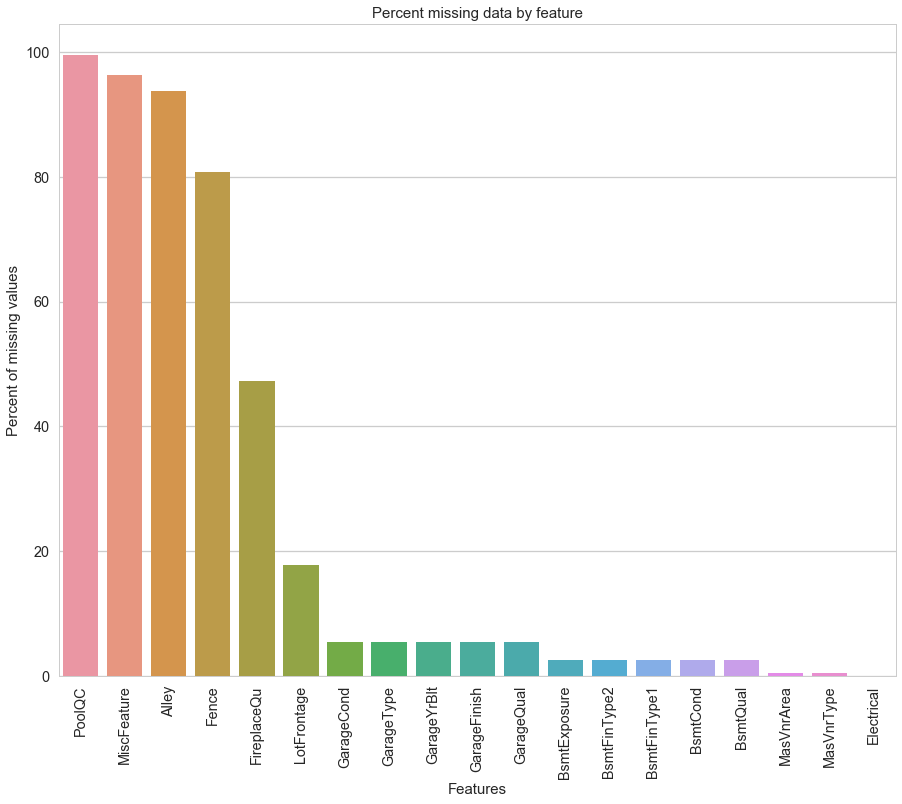

In [7]:
total_missing = train.isnull().sum().sort_values(ascending=False)
ratio_missing = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, ratio_missing], axis=1, keys=['Total', 'Ratio'])
missing_data['Type'] = train[missing_data.index].dtypes

missing_data = missing_data[(missing_data['Total'] > 0)]

# display missing data
missing_data

# Visualize missing data
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sn.barplot(x=missing_data.index, y=missing_data['Ratio']*100.0)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Inferences**

- A lot of features have missing values, need to be deal with it.

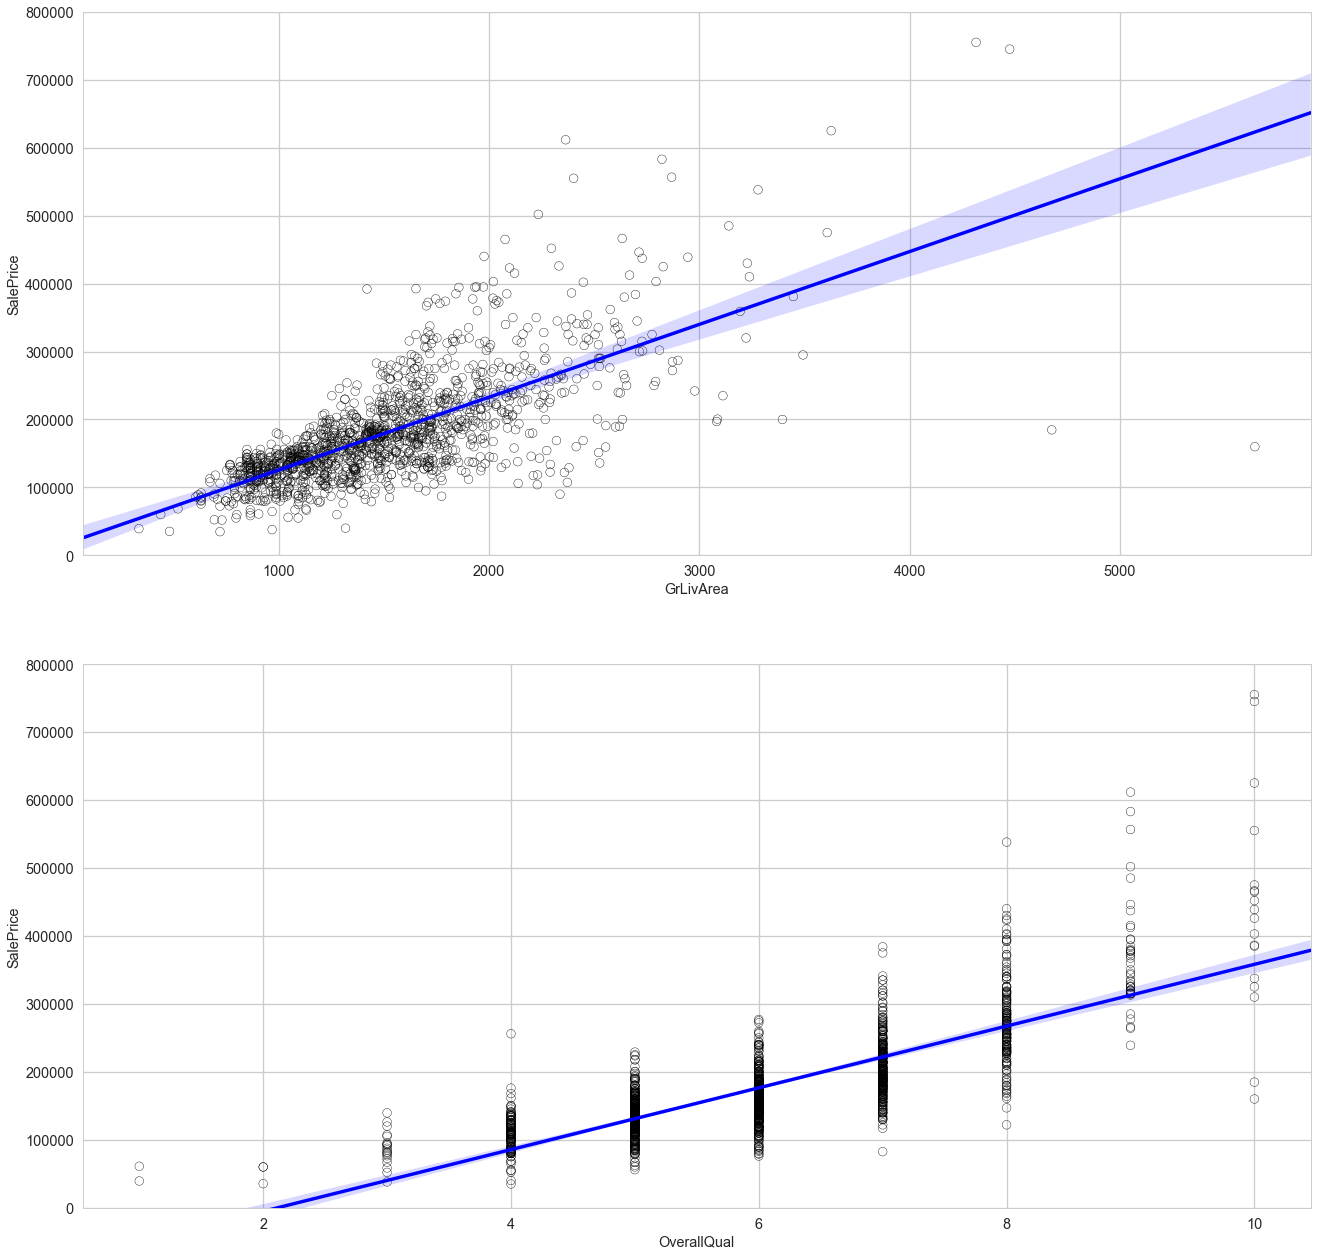

In [8]:
# Get correlation
corr = train.select_dtypes(include=['float64', 'int64']).iloc[:,1:].corr()

# Scatter plotting the top positive related to SalePrice
plt.figure(figsize=(22, 22))
k = 2

# Correlation between attributes with SalePrice
corr_list = corr['SalePrice'].sort_values(axis=0, ascending=False).iloc[1:]

for i in range(k):
    ii = '21'+str(i)
    plt.subplot(ii)
    feature = corr_list.index.values[i]
    plt.scatter(train[feature], train['SalePrice'], facecolors='none', edgecolors='k', s=75)
    sn.regplot(x=feature, y='SalePrice', data=train, scatter=False, color='b')
    ax=plt.gca()
    ax.set_ylim([0,800000])

Inferences:

- In **GrLivArea** scatter plot, unbanlance data distribution, some outlier point when GrLivArea > 5000. We need  to deal with it.
- In **OverallQual** scatter plot, unblance data distribution.

**EDA Summary**

- We have two datasets: train & test. The train for training model, and test for predicting the prices of house.
- Data description
    + Train set has 81 attributes and 1460 records in total.
    + Test set has 80 attributes and 1459 records in total.
- Both of dataset have many type variables both of numerical (int64 or float64) and categorical (object) variables. These will need to handled with the transforming.
- Data have a lot of NaN values. Consider to deal with missing values.
- Have some outlier values in **GrLivArea**. Consider to deal with it.

## 2. Preprocessing Data & Feature Engineering

1. Label encode
2. Fill missing data
3. Deal outlier

Label Encoding - help to transform all non-numeric values to numeric values.

In [9]:
def label_encoding(df):
    cat_features = df.select_dtypes(include=['object']).columns

    lbl = LabelEncoder()

    for col in cat_features:
        lbl.fit(list(df[col].values.astype('str')))

    df[col] = lbl.transform(list(df[col].values.astype('str')))
    
    return df

In [10]:
train = label_encoding(train)
test = label_encoding(test)

Deal with missing values by zero

In [11]:
train = train.replace([-np.inf, np.inf], 0.0)
train = train.fillna(0.0)

test = test.replace([-np.inf, np.inf], 0.0)
test = test.fillna(0.0)

Remove outlier

In [12]:
train.drop(train[(train['GrLivArea'] > 5000)].index, inplace=True)

## 3. Apply Machine Learning Algorithm

Using simple moddel Linear Regression from sklearn

In [13]:
ignore_cols = ['Id', 'SalePrice']
train_features = [col for col in train.select_dtypes(include=['float64', 'int64']).columns if col not in ignore_cols]

X = train[train_features].copy()
y = np.log1p(train['SalePrice'])

# Linear Regression estimator
clf = LinearRegression()

clf.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## 4. Model Evaluation

Try evaluation model with some popular Regression Metrics:

- MSE: Mean Squared Error
- MAE: Mean Absolute Error

Define scoring method by mean squared error

In [14]:
def rmse_score(y_obs, y_hat):
    rmse = np.sqrt(mean_squared_error(y_obs, y_hat))
    return rmse

Define scoring method by mean absolute error

In [15]:
def rmae_score(y_obs, y_hat):
    mae =  np.sqrt(mean_absolute_error(y_obs, y_hat))
    return mae

In [16]:
# EVALUATION MODEL
# 
# Split data prepare for cross-validation
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
clf.fit(X_trn, y_trn)

# Predict y_hat in 20% data splitted
y_hat = clf.predict(X_val)

# Cross-validation score
rmse = rmse_score(y_val, y_hat)
rmae = rmae_score(y_val, y_hat)

print('RMSE score: {:.6f}'.format(rmse))
print('RMAE score:  {:.6f}'.format(rmae))

RMSE score: 0.132984
RMAE score:  0.305434


Inferences:

- With RMSE metric we measuared the average of squared differences between prediction and actual observation is lower than MAE.
- So, I will choose **RMSE** is the main cross-validation metric for this problem

## 5. Predict

In [17]:
preds = np.expm1(clf.predict(test[train_features]))

In [18]:
preds

array([124386.20831462, 139753.44337162, 174342.15404196, ...,
       168876.79148461, 113629.31091258, 239172.29600548])